# Generate melt fraction figure

Initialize. Codes and Jupyter notebook examples are modified from: https://github.com/michpaulatto/ElasticC/tree/master

crystal: Vp= 5.445354, Vs=3.005279, density=2.627000


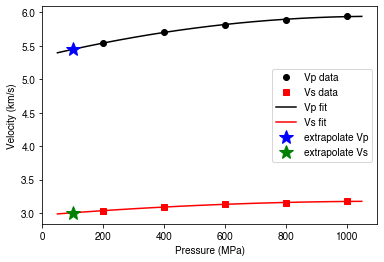

In [1]:
from context import elasticc as el
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('font',family='Helvetica')
# Almost zero. This is needed to avoid some division by zero.
# Need a better solution
zero = 1e-12

# Set up components
#Andesite at different pressures from Christensen and Stanley. We will use this data
# to interpolate to get the velocities at 100 MPa.
pressure=np.array([200,400,600,800,1000])
pressure_ext=np.arange(50,1100,50)
density=2.627
vp=[5.533, 5.712, 5.814,5.885,5.940]
vs=[3.034,3.097,3.13,3.155,3.177]

fitp=np.polyfit(pressure,vp,2)
fits=np.polyfit(pressure,vs,2)

p_want=100 #this is about the pressure at 4 km depth. computed using density*g*depth. density is 2.627.
vp1=fitp[2] + fitp[1]*p_want + fitp[0]*p_want**2
vs1=fits[2] + fits[1]*p_want + fits[0]*p_want**2
ro1=density
print('crystal: Vp= %f, Vs=%f, density=%f'%(vp1,vs1,ro1))


plt.figure()
plt.plot(pressure,vp,'ko',label='Vp data')
plt.plot(pressure,vs,'rs',label='Vs data')

plt.plot(pressure_ext,fitp[2] + fitp[1]*pressure_ext + fitp[0]*pressure_ext**2,'k',label='Vp fit')

plt.plot(pressure_ext,fits[2] + fits[1]*pressure_ext + fits[0]*pressure_ext**2,'r',label='Vs fit')

plt.plot(p_want,vp1,'b*',ms=15,label='extrapolate Vp')
plt.plot(p_want,vs1,'g*',ms=15,label='extrapolate Vs')

plt.xlabel('Pressure (MPa)')
plt.ylabel('Velocity (km/s)')
plt.legend()
plt.show()



In [2]:

scale=vp1/vp[-1]  #ratio of the Vp at 100 MPa compared to those at 1000 Mpa. We use
#this scale to compute the Vp of the molten rock based on the data at 1 GPa.

# print(vp2*scale)

# plt.plot(pressure,vp)
# plt.plot(pressure,vs)

# # Andesite at 200 MPa from Christensen and Stanley
# vp1=5.533
# vs1=3.034
# 

vp2_1gpa=2.8300  #dry andesite melt (0% water) at shallow depth from Ueki, K., & Iwamori, H. (2016). 
#Density and seismic velocity of hydrous melts under crustal and upper mantle conditions.
#the data in the paper shows 2.83 at about 1 Gpa 

# we scale that down for 100 MPa.
vp2=vp2_1gpa*scale
vs2=zero
ro2=2.550 #dry andesite at shallow depth.
print('dry molten rock: Vp= %f, Vs=%f, density=%f'%(vp2,vs2,ro2))

# Moduli of crystals
K1 = ro1*(vp1**2.-4./3.*vs1**2.)
# print(K1)
G1 = ro1*vs1**2.
# print(G1)

# Moduli of melt
K2 = ro2*vp2**2  #1.27e1
G2 = zero

dry molten rock: Vp= 2.594335, Vs=0.000000, density=2.550000


In [3]:
# Initialize volume fractions (melt fraction from 0 to 1)
dc = 5e-3
nc = int(1./dc-1)
c2 = np.linspace(dc,dc*nc,nc)
c1 = 1-c2

# Calculate density of composity as function of melt fraction
roe = el.limits.Voigt(ro1,c1,ro2,c2)

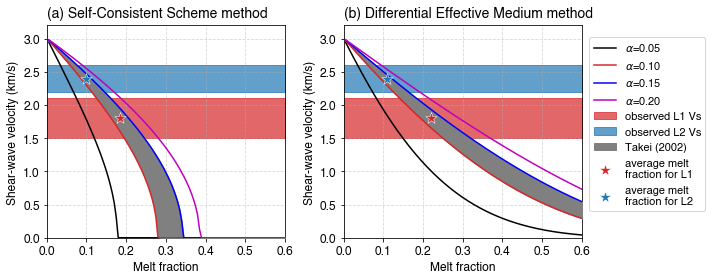

In [4]:
import matplotlib.font_manager as font_manager
Vs_obs1=[1.5,2.1]
Vs_obs2=[2.2,2.6]
pmin=0
pmax=0.6
plt.figure(figsize=(10,4),facecolor='w')
plt.rcParams['svg.fonttype'] = 'none'
textfont={'fontname':'Helvetica'}
legendfont = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)

#test aspect ratio. effective medium
asp_list=np.arange(0.05,0.22,0.05) #range of 0.1-0.15 as the result from Takei (2002)
takei_range=np.array([0.1,0.15])
takei_idx=np.where((asp_list>= takei_range[0]) & (asp_list<= takei_range[1]+0.01))[0]
# asp_list=np.append(asp_list,1.0)
colors=['k','tab:red','b','m']
a1=1
# self-consistency
plt.subplot(1,2,1)

b_Vsr_all=[]
for a in asp_list:  
    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K,G = el.eep.mod_b(K1,0.0,G1,0.0,a1,a,c1,c2)
    # Then use Gassman's fluid substitution
    b_Kr,b_Gr = el.eep.gassman_2(K,G,K1,G1,K2,G2,c2)
    b_Vpr=np.sqrt((b_Kr+4.0/3.0*b_Gr)/roe)
    b_Vsr=np.sqrt(b_Gr/roe)
    b_Vsr_all.append(b_Vsr)


plt.fill_between([pmin,pmax],y1=Vs_obs1[0],y2=Vs_obs1[1],color='tab:red',
                 label='observed L1 Vs',alpha=.7,zorder=0)
plt.fill_between([pmin,pmax],y1=Vs_obs2[0],y2=Vs_obs2[1],color='tab:blue',
                 label='observed L2 Vs',alpha=.7,zorder=0)
plt.fill_between(c2,y1=b_Vsr_all[takei_idx[0]],y2=b_Vsr_all[takei_idx[1]],color=[.5,.5,.5],
                 label='Takei (2002)',alpha=1,zorder=5)

for i in range(len(asp_list)): 
    vtemp=b_Vsr_all[i]  
    plt.plot(c2,vtemp,color=colors[i],label='$\u03B1$=%4.2f'%(asp_list[i]),zorder=10)
# plt.hlines(Vs_obs[0],xmin=pmin,xmax=pmax,colors='k',linestyles='-',lw=2)
# plt.hlines(Vs_obs[1],xmin=pmin,xmax=pmax,colors='k',linestyles='-',lw=2)
# plt.legend(ncol=2)

# plot average estimate.
plt.scatter(0.185,np.mean(Vs_obs1),145,'tab:red',marker='*',edgecolors='w',
            facecolors='tab:red',lw=.5,label='average melt\nfraction for L1',zorder=20)
plt.scatter(0.1,np.mean(Vs_obs2),145,'tab:blue',marker='*',edgecolors='w',
            facecolors='tab:blue',lw=.5,label='average melt\nfraction for L2',zorder=20)

plt.xlim(pmin,pmax)
plt.ylim(0,3.2)
plt.xticks(fontsize=12,**textfont)
plt.yticks(fontsize=12,**textfont)
plt.title('(a) Self-Consistent Scheme method',fontsize=14,loc="left",pad=8,**textfont)
plt.grid('both',ls='--',alpha=0.5)
plt.xlabel('Melt fraction',fontsize=12,**textfont)
plt.ylabel('Shear-wave velocity (km/s)',fontsize=12,**textfont)

##########################################
plt.subplot(1,2,2)
a_Vsr_all=[]
for a in asp_list:    
    a_Ku,a_Gu = el.eep.dem(K1,K2,G1,G2,a,c2)
    a_Vpu=np.sqrt((a_Ku+4.0/3.0*a_Gu)/roe)
    a_Vsu=np.sqrt(a_Gu/roe)
    #dry moduli
    K,G = el.eep.dem(K1,0.0,G1,0.0,a,c2)
    # Then use Gassman's fluid substitution
    # Relaxed.
    a_Kr,a_Gr = el.eep.gassman_2(K,G,K1,G1,K2,G2,c2)
    a_Vpr=np.sqrt((a_Kr+4.0/3.0*a_Gr)/roe)
    a_Vsr=np.sqrt(a_Gr/roe)
    a_Vsr_all.append(a_Vsr)
#
plt.fill_between([pmin,pmax],y1=Vs_obs1[0],y2=Vs_obs1[1],color='tab:red',
                 label='observed L1 Vs',alpha=.7,zorder=0)
plt.fill_between([pmin,pmax],y1=Vs_obs2[0],y2=Vs_obs2[1],color='tab:blue',
                 label='observed L2 Vs',alpha=.7,zorder=0)
plt.fill_between(c2,y1=a_Vsr_all[takei_idx[0]],y2=a_Vsr_all[takei_idx[1]],color=[.5,.5,.5],
                 label='Takei (2002)',alpha=1,zorder=5)

for i in range(len(asp_list)):    
    plt.plot(c2,a_Vsr_all[i],color=colors[i],label='$\u03B1$=%4.2f'%(asp_list[i]),zorder=10)

# plot average estimate.
plt.scatter(0.22,np.mean(Vs_obs1),145,'tab:red',marker='*',edgecolors='w',
            facecolors='tab:red',lw=.5,label='average melt\nfraction for L1',zorder=20)
plt.scatter(0.11,np.mean(Vs_obs2),145,'tab:blue',marker='*',edgecolors='w',
            facecolors='tab:blue',lw=.5,label='average melt\nfraction for L2',zorder=20)
# plt.legend(ncol=2)
plt.legend(bbox_to_anchor=(1.01, 0.1),ncol=1,fontsize=11,prop=legendfont)
plt.xlim(pmin,pmax)
plt.ylim(0,3.2)
plt.xticks(fontsize=12,**textfont)
plt.yticks(fontsize=12,**textfont)
plt.title('(b) Differential Effective Medium method',fontsize=14,loc="left",pad=8,**textfont)
plt.grid('both',ls='--',alpha=0.5)
plt.xlabel('Melt fraction',fontsize=12,**textfont)
plt.ylabel('Shear-wave velocity (km/s)',fontsize=12,**textfont)

#test critical porosity
# plt.subplot(1,3,3)
# plt.fill_between([pmin,pmax],y1=Vs_obs[0],y2=Vs_obs[1],color=[.4,.4,.4],label='observed Vs')
# porosity_list=np.arange(0.2,0.55,0.1)
# for p in porosity_list:
#     c_Kr,c_Gr = el.critical.mod_c(K1,K2,G1,G2,p,c2)
#     c_Vpr=np.sqrt((c_Kr+4.0/3.0*c_Gr)/roe)
#     c_Vsr=np.sqrt(c_Gr/roe)
#     plt.plot(c2,c_Vsr,label='porosity:%3.1f'%(p))
# #
# plt.legend()
# plt.xlim(pmin,pmax)
# plt.ylim(0,3.5)
# plt.title('critical porosity')
# plt.grid()
# plt.xlabel('Melt fraction')
# plt.ylabel('Seismic velocity (km/s)')

plt.tight_layout()
plt.savefig("Figure-X_melt_fraction.pdf",format='pdf',transparent=True,dpi=300)
plt.show()


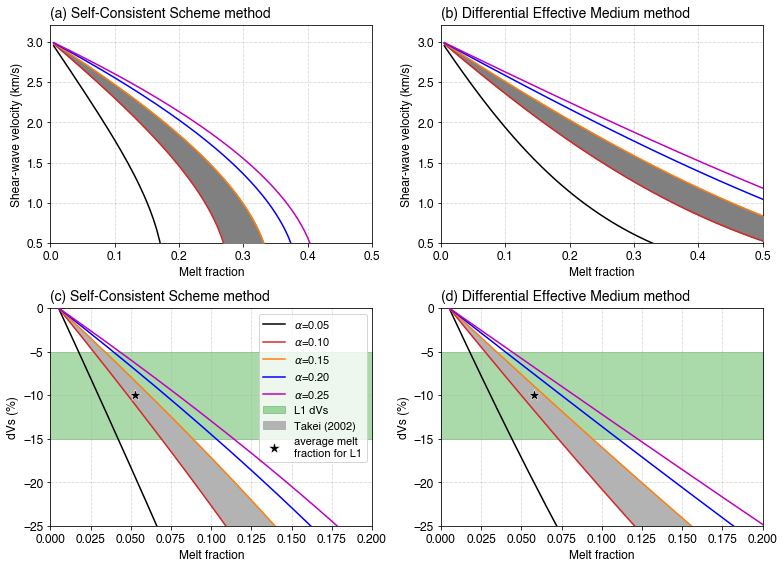

SCS:  0.05, error:  0.03
DEM:  0.06, error:  0.03


In [16]:
Vs_obs1=[-15,-5]#[1.5,2.1]
Vs_obs2=[-10,-5]#[2.2,2.6]
pmin=0
pmax=0.2
pmin_abs=0
pmax_abs=0.5

plt.figure(figsize=(11,8),facecolor='w')
plt.rcParams['svg.fonttype'] = 'none'
textfont={'fontname':'Helvetica'}
legendfont = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)

#test aspect ratio. effective medium
asp_list=np.arange(0.05,0.26,0.05) #range of 0.1-0.15 as the result from Takei (2002)
takei_range=np.array([0.1,0.15])
takei_idx=np.where((asp_list>= takei_range[0]) & (asp_list<= takei_range[1]+0.01))[0]
# asp_list=np.append(asp_list,1.0)
colors=['k','tab:red','tab:orange','b','m']
a1=1

# self-consistency

b_Vsr_all=[]
b_Vsr_all_dv=[]
for a in asp_list:  
    # Relaxed, low frequency limit
    # Calculate dry moduli first (void fill)
    K,G = el.eep.mod_b(K1,0.0,G1,0.0,a1,a,c1,c2)
    # Then use Gassman's fluid substitution
    b_Kr,b_Gr = el.eep.gassman_2(K,G,K1,G1,K2,G2,c2)
    b_Vpr=np.sqrt((b_Kr+4.0/3.0*b_Gr)/roe)
    b_Vsr=np.sqrt(b_Gr/roe)
    b_Vsr_all.append(b_Vsr)
    b_Vsr_all_dv.append(100*(b_Vsr - b_Vsr[0])/b_Vsr[0])

# absolute velocity melt first
plt.subplot(2,2,1)
plt.fill_between(c2,y1=b_Vsr_all[takei_idx[0]],y2=b_Vsr_all[takei_idx[1]],color=[.5,.5,.5],
                 label='Takei (2002)',alpha=1,zorder=5)

for i in range(len(asp_list)): 
    vtemp=b_Vsr_all[i]  
    plt.plot(c2,vtemp,color=colors[i],label='$\u03B1$=%4.2f'%(asp_list[i]),zorder=10)

plt.xlim(pmin_abs,pmax_abs)
plt.ylim(0.5,3.2)
plt.xticks(fontsize=12,**textfont)
plt.yticks(fontsize=12,**textfont)
plt.title('(a) Self-Consistent Scheme method',fontsize=14,loc="left",pad=8,**textfont)
plt.grid('both',ls='--',alpha=0.5)
plt.xlabel('Melt fraction',fontsize=12,**textfont)
plt.ylabel('Shear-wave velocity (km/s)',fontsize=12,**textfont)

########
plt.subplot(2,2,3)
plt.fill_between([pmin,pmax],y1=Vs_obs1[0],y2=Vs_obs1[1],color='tab:green',
                 label='L1 dVs',alpha=.4,zorder=0)
plt.fill_between(c2,y1=b_Vsr_all_dv[takei_idx[0]],y2=b_Vsr_all_dv[takei_idx[1]],color=[.7,.7,.7],
                 label='Takei (2002)',alpha=1,zorder=5)

for i in range(len(asp_list)): 
    dvtemp=b_Vsr_all_dv[i]   
    plt.plot(c2,dvtemp,color=colors[i],label='$\u03B1$=%4.2f'%(asp_list[i]),zorder=10)

# plot average estimate.
mrange_a=[0.025,0.08]
amean=np.mean(mrange_a)
plt.scatter(amean,np.mean(Vs_obs1),145,'k',marker='*',edgecolors='w',
            facecolors='tab:red',lw=.5,label='average melt\nfraction for L1',zorder=20)
# plt.scatter(0.1,np.mean(Vs_obs2),145,'tab:blue',marker='*',edgecolors='w',
#             facecolors='tab:blue',lw=.5,label='average melt\nfraction for L2',zorder=20)
plt.legend(ncol=1,fontsize=11,prop=legendfont)
plt.xlim(pmin,pmax)
plt.ylim(-25,0)
plt.xticks(fontsize=12,**textfont)
plt.yticks(fontsize=12,**textfont)
plt.title('(c) Self-Consistent Scheme method',fontsize=14,loc="left",pad=8,**textfont)
plt.grid('both',ls='--',alpha=0.5)
plt.xlabel('Melt fraction',fontsize=12,**textfont)
plt.ylabel('dVs (%)',fontsize=12,**textfont)

##########################################
a_Vsr_all=[]
a_Vsr_all_dv=[]
for a in asp_list:    
    a_Ku,a_Gu = el.eep.dem(K1,K2,G1,G2,a,c2)
    a_Vpu=np.sqrt((a_Ku+4.0/3.0*a_Gu)/roe)
    a_Vsu=np.sqrt(a_Gu/roe)
    #dry moduli
    K,G = el.eep.dem(K1,0.0,G1,0.0,a,c2)
    # Then use Gassman's fluid substitution
    # Relaxed.
    a_Kr,a_Gr = el.eep.gassman_2(K,G,K1,G1,K2,G2,c2)
    a_Vpr=np.sqrt((a_Kr+4.0/3.0*a_Gr)/roe)
    a_Vsr=np.sqrt(a_Gr/roe)
    a_Vsr_all.append(a_Vsr)
    a_Vsr_all_dv.append(100*(a_Vsr - a_Vsr[0])/a_Vsr[0])

# Vs melt
plt.subplot(2,2,2)
plt.fill_between(c2,y1=a_Vsr_all[takei_idx[0]],y2=a_Vsr_all[takei_idx[1]],color=[.5,.5,.5],
                 label='Takei (2002)',alpha=1,zorder=5)

for i in range(len(asp_list)):    
    plt.plot(c2,a_Vsr_all[i],color=colors[i],label='$\u03B1$=%4.2f'%(asp_list[i]),zorder=10)

# plt.legend(bbox_to_anchor=(1.01, 0.1),ncol=1,fontsize=11,prop=legendfont)
plt.xlim(pmin_abs,pmax_abs)
plt.ylim(0.5,3.2)
plt.xticks(fontsize=12,**textfont)
plt.yticks(fontsize=12,**textfont)
plt.title('(b) Differential Effective Medium method',fontsize=14,loc="left",pad=8,**textfont)
plt.grid('both',ls='--',alpha=0.5)
plt.xlabel('Melt fraction',fontsize=12,**textfont)
plt.ylabel('Shear-wave velocity (km/s)',fontsize=12,**textfont)


# dVs melt
plt.subplot(2,2,4)
plt.fill_between([pmin,pmax],y1=Vs_obs1[0],y2=Vs_obs1[1],color='tab:green',
                 label='L1 dVs',alpha=.4,zorder=0)
plt.fill_between(c2,y1=a_Vsr_all_dv[takei_idx[0]],y2=a_Vsr_all_dv[takei_idx[1]],color=[.7,.7,.7],
                 label='Takei (2002)',alpha=1,zorder=5)

for i in range(len(asp_list)):   
    dvtemp=a_Vsr_all_dv[i]  
    plt.plot(c2,dvtemp,color=colors[i],label='$\u03B1$=%4.2f'%(asp_list[i]),zorder=10)

# plot average estimate.
mrange_b=[0.025,0.09]
bmean=np.mean(mrange_b)
plt.scatter(bmean,np.mean(Vs_obs1),145,'k',marker='*',edgecolors='w',
            facecolors='tab:black',lw=.5,label='average melt\nfraction for L1',zorder=20)
# plt.legend(ncol=1,fontsize=11,prop=legendfont)
plt.xlim(pmin,pmax)
plt.ylim(-25,0)
plt.xticks(fontsize=12,**textfont)
plt.yticks(fontsize=12,**textfont)
plt.title('(d) Differential Effective Medium method',fontsize=14,loc="left",pad=8,**textfont)
plt.grid('both',ls='--',alpha=0.5)
plt.xlabel('Melt fraction',fontsize=12,**textfont)
plt.ylabel('dVs (%)',fontsize=12,**textfont)

plt.tight_layout()
plt.savefig("Figure-X_melt_fraction_all.pdf",format='pdf',transparent=True,dpi=300)
plt.show()

##
print('SCS: %5.2f, error: %5.2f'%(amean,mrange_a[1]-amean))
print('DEM: %5.2f, error: %5.2f'%(bmean,mrange_b[1]-bmean))